## Analyzing Sentiment Data with Finbert

**Load Model**

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import feedparser
import requests


MODEL_NAME = "ProsusAI/finbert" #tabularisai/ModernFinBERT" or "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()

id2label = model.config.id2label  # e.g. {0: 'negative', 1: 'neutral', 2: 'positive'}

print(f"{MODEL_NAME} loaded")

c:\Users\skurono\Desktop\SCMC\scmc-2025\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ProsusAI/finbert loaded


**Sanity Inference Check**

In [2]:
pipe = pipeline("text-classification", model=MODEL_NAME)

#inference check (positive)
print(pipe('Stocks rallied and the British pound gained'))

Device set to use cpu


[{'label': 'positive', 'score': 0.6949422359466553}]


**Load Data and Check master DF**

In [33]:
from collections import Counter
import re
import pandas as pd
master = pd.read_csv('./processed_data/final/master_corpus.csv')
#Check rows and validate final dataset
print(master.head())
print(master["ticker"].unique())

df = master.copy()
TEXT_COL = "text"   # change if needed

assert TEXT_COL in df.columns, f"Missing column: {TEXT_COL}"

# --- basic integrity ---
print("Rows:", len(df))
print("Columns:", list(df.columns))

# enforce string + fill NaNs
df[TEXT_COL] = df[TEXT_COL].astype(str).fillna("")

# --- empty / whitespace detection ---
df["is_empty"] = df[TEXT_COL].str.strip().eq("")
print("\nEmpty rows:", df["is_empty"].sum())

# --- extremely short fragments ---
df["char_len"] = df[TEXT_COL].str.len()
print("Rows < 20 chars:", (df["char_len"] < 20).sum())

# --- extremely long rows (will truncate at 512 tokens) ---
print("Rows > 2000 chars:", (df["char_len"] > 2000).sum())
print("Max length:", df["char_len"].max())

# peek at extremes
display(df.sort_values("char_len").head(5)[[TEXT_COL,"char_len"]])
display(df.sort_values("char_len").tail(5)[[TEXT_COL,"char_len"]])

# --- duplicate detection ---
dup_rows = df.duplicated(subset=[TEXT_COL]).sum()
print("\nDuplicate text rows:", dup_rows)

# --- repeated boilerplate detector (top 10 repeated snippets) ---
most_common = Counter(df[TEXT_COL]).most_common(10)
print("\nMost repeated texts:")
for t, c in most_common:
    if c > 5:
        print(f"  {c}x ->", t[:120].replace("\n"," ") + "...")

# --- garbage / artifact heuristic flags ---
def looks_like_html(s):
    return bool(re.search(r"<[^>]+>", s))

def looks_like_json(s):
    return s.strip().startswith("{") and s.strip().endswith("}")

df["html_like"] = df[TEXT_COL].apply(looks_like_html)
df["json_like"] = df[TEXT_COL].apply(looks_like_json)

print("\nPossible HTML rows:", df["html_like"].sum())
print("Possible JSON blobs:", df["json_like"].sum())

# --- language / encoding artifacts (optional heuristic) ---
df["high_symbol_ratio"] = (df[TEXT_COL].str.count(r"[^A-Za-z0-9\s.,;:$%-]") / df["char_len"].clip(lower=1)) > 0.25
print("Rows with many strange symbols:", df["high_symbol_ratio"].sum())



   Unnamed: 0                                                 id  \
0           0  20231103_Digital_Sales_Poised_to_Double_by_202...   
1           1  20231103_Digital_Sales_Poised_to_Double_by_202...   
2           2  20231103_Digital_Sales_Poised_to_Double_by_202...   
3           3  20231103_Digital_Sales_Poised_to_Double_by_202...   
4           4  20231103_Digital_Sales_Poised_to_Double_by_202...   

                                           report_id ticker company date  \
0  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   
1  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   
2  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   
3  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   
4  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   

      source       doc_type item section_type  \
0  bloomberg  research_note  NaN       thesis   
1  bloomberg  research_note  NaN    

,text,char_len
1186,% ),3
2525,1q26,4
2046,peers,5
2927,peers,5
2110,peers,5


,text,char_len
3185,Our expansive and diverse range of fashion app...,2617
3351,"As at August 31, 2025, the fair value of the e...",2627
3398,We manage liquidity risk by continuously monit...,2674
5202,"Three Months Ended \n August 31, \n __________...",3063
5169,"Three Months Ended \n August 31, \n __________...",3094



Duplicate text rows: 1313

Most repeated texts:
  44x -> additional resources : analyzer | bi » earnings calendar | evts »...
  14x -> events ), with 4q net revenue ( ex - 53rd week ) expected to increase 28 - 31 %, according to guidance gross margin expa...
  13x -> expected to gain 20 - 23. 5 %, based on guidance gross margin expanded 359 bps to 43. 8 %, 250 bps ahead of consensus, d...
  13x -> post - 1q earnings outlook : aritzia could surpass 2q guidance for 19 - 22 % sales growth ( vs. analysts'20. 8 % ) and i...
  13x -> expected to increase 19 - 22 %, according to guidance gross margin expanded 320 bps to 47. 2 %, 20 bps ahead of consensu...
  13x -> to increase 3 - 7 %, based on guidance gross margin expanded 522 bps to 40. 2 %, 71 bps ahead of consensus'39. 5 %, on l...
  13x -> rise 7 - 10 %, based on guidance gross margin climbed 510 bps to 44 %, 64 bps ahead of consensus'43. 4 %, on lower markd...
  12x -> post - 3q earnings outlook : aritzia could meet the high end of 4q

**Run Model**

In [13]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Paths
MASTER_PATH = "./processed_data/final/master_corpus.csv"
OUTPUT_PATH = "./processed_data/final/master_corpus_finbert.csv"

# Load data
df = master
print(df.shape)

# FinBERT model
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def score_batch(texts):
    enc = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = model(**enc).logits
        probs = out.softmax(dim=-1).cpu().numpy()
    return probs  # columns: [neg, neu, pos]

# Run in batches
batch_size = 16
neg_list, neu_list, pos_list = [], [], []
for i in range(0, len(df), batch_size):
    batch = df["text"].iloc[i:i+batch_size].fillna("").tolist()
    probs = score_batch(batch)
    neg_list.extend(probs[:, 0])
    neu_list.extend(probs[:, 1])
    pos_list.extend(probs[:, 2])
    if i % 100 == 0:
        print(f"scored {i} / {len(df)}")

df["finbert_neg"] = neg_list
df["finbert_neu"] = neu_list
df["finbert_pos"] = pos_list
df["finbert_score"] = df["finbert_pos"] - df["finbert_neg"]  # simple sentiment score

df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved {len(df)} rows -> {OUTPUT_PATH}")
df.head()


(5945, 19)
scored 0 / 5945
scored 400 / 5945
scored 800 / 5945
scored 1200 / 5945
scored 1600 / 5945
scored 2000 / 5945
scored 2400 / 5945
scored 2800 / 5945
scored 3200 / 5945
scored 3600 / 5945
scored 4000 / 5945
scored 4400 / 5945
scored 4800 / 5945
scored 5200 / 5945
scored 5600 / 5945
Saved 5945 rows -> ./processed_data/final/master_corpus_finbert.csv


,id,report_id,ticker,company,date,source,doc_type,item,section_type,section_heading,chunk_index,page_start,page_end,text,source_file,finbert_neg,finbert_neu,finbert_pos,finbert_score
0,20231103_Digital_Sales_Poised_to_Double_by_202...,20231103_Digital_Sales_Poised_to_Double_by_202...,ATZ,NaN,NaN,bloomberg,research_note,NaN,thesis,"Aritzia Sales Could Double on US Expansion, Gr...",0.0,1.0,1,( bloomberg intelligence ) - - aritzia has a l...,nlp\raw_data\bloomberg\atz_research\20231103_D...,0.889320,0.008364,0.102316,-0.787004
1,20231103_Digital_Sales_Poised_to_Double_by_202...,20231103_Digital_Sales_Poised_to_Double_by_202...,ATZ,NaN,NaN,bloomberg,research_note,NaN,growth,1. Setting Up Significant White Space Potential,1.0,1.0,1,aritzia's plan to lift revenue 60 % to c $ 3. ...,nlp\raw_data\bloomberg\atz_research\20231103_D...,0.842159,0.007463,0.150377,-0.691782
2,20231103_Digital_Sales_Poised_to_Double_by_202...,20231103_Digital_Sales_Poised_to_Double_by_202...,ATZ,NaN,NaN,bloomberg,research_note,NaN,growth,"Private Brands Are 95% of Sales: Wilfred 28%, ...",2.0,1.0,1,"26 %, super puff 7 - 8 %, denim forum, sunday ...",nlp\raw_data\bloomberg\atz_research\20231103_D...,0.048370,0.018046,0.933584,0.885214
3,20231103_Digital_Sales_Poised_to_Double_by_202...,20231103_Digital_Sales_Poised_to_Double_by_202...,ATZ,NaN,NaN,bloomberg,research_note,NaN,growth,2. Margin Can Increase at Least 500 Bps in 2024,3.0,1.0,2,aritzia's ebitda margin could expand by 500 bp...,nlp\raw_data\bloomberg\atz_research\20231103_D...,0.114497,0.166290,0.719213,0.604716
4,20231103_Digital_Sales_Poised_to_Double_by_202...,20231103_Digital_Sales_Poised_to_Double_by_202...,ATZ,NaN,NaN,bloomberg,research_note,NaN,growth,3. Digital Sales Poised to Double by 2027 (Cor...,4.0,2.0,2,aritzia's c $ 800 million of digital sales cou...,nlp\raw_data\bloomberg\atz_research\20231103_D...,0.562942,0.010367,0.426692,-0.136250


**Evaluate and Calculate Final Scores**

In [28]:
print(df["ticker"].unique())
print(df["source"].unique())

score_df = df[[
    "id",
    "ticker",
    "date",
    "source",
    "section_heading",
    "text",
    "finbert_neg",
    "finbert_neu",
    "finbert_pos"
]]

score_df = score_df.copy()


print(score_df.head())

score_df[["finbert_pos","finbert_neg","finbert_neu"]] = (
    score_df[["finbert_pos","finbert_neg","finbert_neu"]].astype(float)
)
score_df.loc[:, "cwds_score"] = (score_df["finbert_pos"]-score_df["finbert_neg"]) * (1 - score_df["finbert_neu"])
score_df["cwds_score"] = score_df["cwds_score"].fillna(0)
print(score_df["cwds_score"])

['ATZ' 'LULU' 'NKE' nan 'nike' 'lulu']
['bloomberg' 'mda_canada' 'sec' 'press_release' 'yfinance' 'news_article'
 'news']
                                                  id ticker date     source  \
0  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ  NaN  bloomberg   
1  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ  NaN  bloomberg   
2  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ  NaN  bloomberg   
3  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ  NaN  bloomberg   
4  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ  NaN  bloomberg   

                                     section_heading  \
0  Aritzia Sales Could Double on US Expansion, Gr...   
1    1. Setting Up Significant White Space Potential   
2  Private Brands Are 95% of Sales: Wilfred 28%, ...   
3    2. Margin Can Increase at Least 500 Bps in 2024   
4  3. Digital Sales Poised to Double by 2027 (Cor...   

                                                text  finbert_neg 

**Calculate Metrics for table**

In [27]:
# ---------------------------------------------------------------------
# Config: adjust thresholds if needed
# ---------------------------------------------------------------------
TICKERS = ["ATZ", "LULU", "NKE",  "nike","lulu", "atz"]

POS_TAIL_THRESH = 0.30   # high-confidence positive sentiment
NEG_TAIL_THRESH = -0.30  # high-confidence negative sentiment
NEU_THRESH       = 0.60  # strongly neutral if finbert_neu >= this

# ---------------------------------------------------------------------
# 1. Filter to relevant tickers and ensure needed columns exist
# ---------------------------------------------------------------------
required_cols = {
    "ticker", "cwds_score",
    "finbert_neg", "finbert_neu", "finbert_pos"
}
missing = required_cols - set(score_df.columns)
if missing:
    raise ValueError(f"Missing required columns in score_df: {missing}")

sub = score_df[score_df["ticker"].isin(TICKERS)].copy()

# Ensure numeric types
sub[["cwds_score", "finbert_neg", "finbert_neu", "finbert_pos"]] = (
    sub[["cwds_score", "finbert_neg", "finbert_neu", "finbert_pos"]].astype(float)
)

g = sub.groupby("ticker")

# ---------------------------------------------------------------------
# 2. Core statistics per ticker
# ---------------------------------------------------------------------
mean_sent    = g["cwds_score"].mean()              # Market tone
median_sent  = g["cwds_score"].median()            # Robust central tendency
std_sent     = g["cwds_score"].std(ddof=0)         # Dispersion (σ)

# Tail quantile (optional, downside severity metric)
tail5_sent   = g["cwds_score"].quantile(0.05)      # 5% worst-sentiment quantile

# ---------------------------------------------------------------------
# 3. Tail percentages and neutral share
# ---------------------------------------------------------------------
neg_tail_pct = g.apply(lambda df: (df["cwds_score"] <= NEG_TAIL_THRESH).mean()) * 100.0
pos_tail_pct = g.apply(lambda df: (df["cwds_score"] >= POS_TAIL_THRESH).mean()) * 100.0

# Neutral share: fraction of highly neutral passages (low info density)
neutral_share_pct = g.apply(lambda df: (df["finbert_neu"] >= NEU_THRESH).mean()) * 100.0

# ---------------------------------------------------------------------
# 4. Assemble a detailed metrics table (for debugging / analysis)
# ---------------------------------------------------------------------
metrics_by_ticker = pd.DataFrame({
    "Mean Sentiment": mean_sent,
    "Median Sentiment": median_sent,
    "Dispersion (σ)": std_sent,
    "Tail-5% Sentiment": tail5_sent,
    "Neg-Tail %": neg_tail_pct,
    "Pos-Tail %": pos_tail_pct,
    "Neutral Share %": neutral_share_pct,
})

# reorder tickers if some are missing
metrics_by_ticker = metrics_by_ticker.reindex(
    [t for t in TICKERS if t in metrics_by_ticker.index]
)

print("=== Detailed metrics by ticker ===")
display(metrics_by_ticker)

# ---------------------------------------------------------------------
# 5. SCMC slide-ready table:
#    Metric | ATZ | LULU | NKE | Interpretation
# ---------------------------------------------------------------------
slide_base = pd.DataFrame({
    "Mean Sentiment": mean_sent,
    "Dispersion (σ)": std_sent,
    "Neg-Tail %": neg_tail_pct,
    "Pos-Tail %": pos_tail_pct,
    "Neutral Share": neutral_share_pct,
}).T  # metrics as rows

slide_base.index.name = "Metric"

# enforce ticker column order
slide_base = slide_base[[t for t in TICKERS if t in slide_base.columns]]

interpretation = {
    "Mean Sentiment":  "Market tone",
    "Dispersion (σ)":  "Uncertainty / convexity",
    "Neg-Tail %":      "Downside perception",
    "Pos-Tail %":      "Catalyst leverage",
    "Neutral Share":   "Info density",
}

slide_base["Interpretation"] = slide_base.index.map(interpretation)

# final slide-ready table
slide_table = slide_base.reset_index()

print("\n=== SCMC slide-ready table ===")
display(slide_table)

=== Detailed metrics by ticker ===


C:\Users\skurono\AppData\Local\Temp\ipykernel_16592\3464920084.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neg_tail_pct = g.apply(lambda df: (df["cwds_score"] <= NEG_TAIL_THRESH).mean()) * 100.0
C:\Users\skurono\AppData\Local\Temp\ipykernel_16592\3464920084.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pos_tail_pct = g.apply(lambda df: (df["cwds_score"] >= POS_TAIL_THRESH).mean()) * 100.0
C:\Users\sku

,Mean Sentiment,Median Sentiment,Dispersion (σ),Tail-5% Sentiment,Neg-Tail %,Pos-Tail %,Neutral Share %
ticker,,,,,,,
ATZ,0.076193,0.243805,0.744765,-0.913400,36.131632,49.429147,6.581598
LULU,0.328350,0.469059,0.555524,-0.853074,12.335835,52.392120,28.986867
NKE,0.300420,0.492635,0.586646,-0.861693,16.374539,54.520295,20.156827
nike,0.606119,0.793007,0.388976,-0.021745,3.846154,76.923077,11.538462
lulu,0.787585,0.867958,0.186419,0.348614,0.000000,94.444444,0.000000



=== SCMC slide-ready table ===


ticker,Metric,ATZ,LULU,NKE,nike,lulu,Interpretation
0,Mean Sentiment,0.076193,0.328350,0.300420,0.606119,0.787585,Market tone
1,Dispersion (σ),0.744765,0.555524,0.586646,0.388976,0.186419,Uncertainty / convexity
2,Neg-Tail %,36.131632,12.335835,16.374539,3.846154,0.000000,Downside perception
3,Pos-Tail %,49.429147,52.392120,54.520295,76.923077,94.444444,Catalyst leverage
4,Neutral Share,6.581598,28.986867,20.156827,11.538462,0.000000,Info density


**Visualize Data**

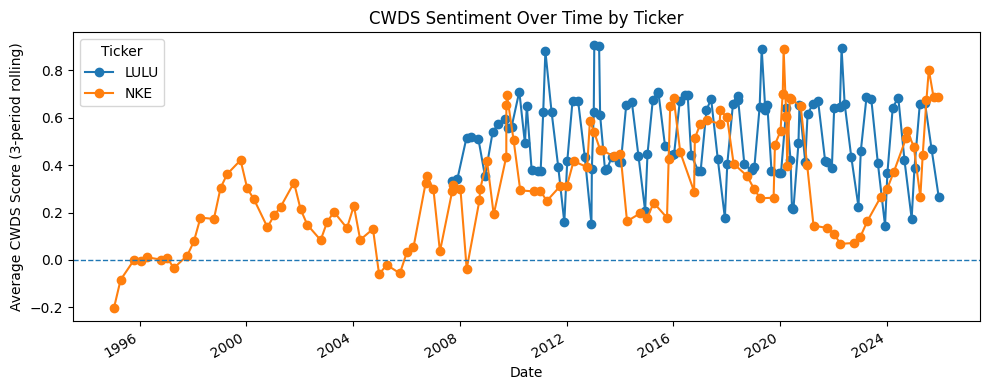

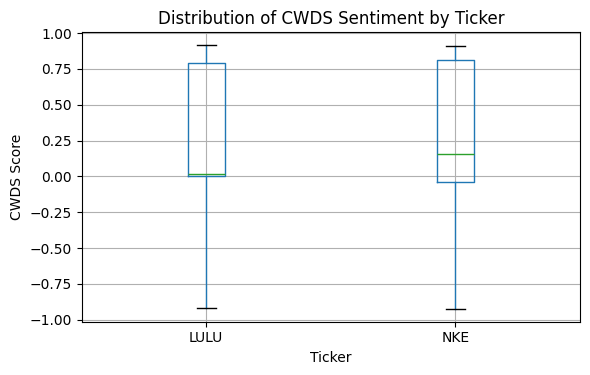

C:\Users\skurono\AppData\Local\Temp\ipykernel_16592\3786272650.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neg_tail_pct = g.apply(lambda d: (d["cwds_score"] <= NEG_TAIL_THRESH).mean()) * 100.0
C:\Users\skurono\AppData\Local\Temp\ipykernel_16592\3786272650.py:76: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pos_tail_pct = g.apply(lambda d: (d["cwds_score"] >= POS_TAIL_THRESH).mean()) * 100.0
C:\Users\skurono

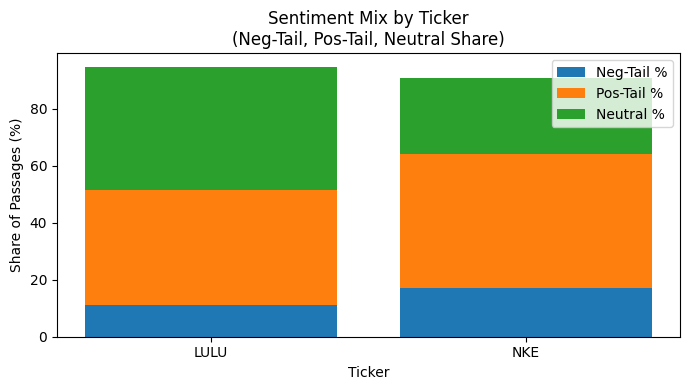

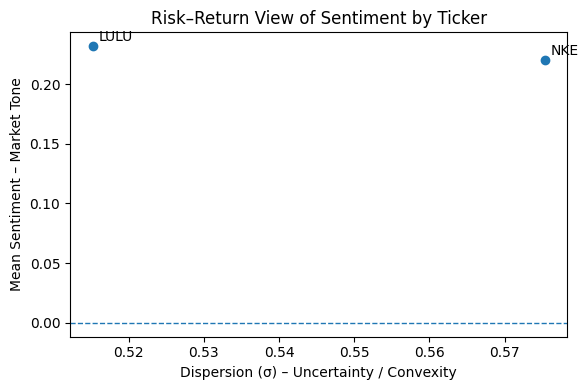

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Ensure types and basic filtering
# ---------------------------------------------------------------------
df_plot = score_df.copy()

# Make sure date is datetime and drop rows without valid date
df_plot["date"] = pd.to_datetime(df_plot["date"], errors="coerce")
df_plot = df_plot.dropna(subset=["date", "ticker", "cwds_score"])

# If you only care about these three tickers, keep this; otherwise remove the line

df_plot = df_plot[df_plot["ticker"].isin(focus_tickers)]

# Ensure numeric
df_plot["cwds_score"] = df_plot["cwds_score"].astype(float)
df_plot["finbert_neu"] = df_plot["finbert_neu"].astype(float)

# Tail / neutrality thresholds (match your metrics cell)
POS_TAIL_THRESH = 0.30
NEG_TAIL_THRESH = -0.30
NEU_THRESH       = 0.60

# ---------------------------------------------------------------------
# 1) Time series: average sentiment by ticker over time (rolling smooth)
# ---------------------------------------------------------------------
ts = (
    df_plot
    .groupby(["date", "ticker"])["cwds_score"]
    .mean()
    .reset_index()
    .sort_values(["ticker", "date"])
)

fig, ax = plt.subplots(figsize=(10, 4))

for ticker, grp in ts.groupby("ticker"):
    # light smoothing so the lines are not too noisy
    y = grp["cwds_score"].rolling(window=3, min_periods=1).mean()
    ax.plot(grp["date"], y, marker="o", linewidth=1.5, label=ticker)

ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("CWDS Sentiment Over Time by Ticker")
ax.set_xlabel("Date")
ax.set_ylabel("Average CWDS Score (3-period rolling)")
ax.legend(title="Ticker")
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 2) Distribution view: boxplot of sentiment by ticker
#    (shows median, dispersion, tail behaviour)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

df_plot.boxplot(column="cwds_score", by="ticker", ax=ax)
ax.set_title("Distribution of CWDS Sentiment by Ticker")
ax.set_xlabel("Ticker")
ax.set_ylabel("CWDS Score")
plt.suptitle("")  # remove automatic pandas title

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3) Tail structure: Pos-tail %, Neg-tail %, Neutral share per ticker
#    (good for a “sentiment profile” slide)
# ---------------------------------------------------------------------
g = df_plot.groupby("ticker")

neg_tail_pct = g.apply(lambda d: (d["cwds_score"] <= NEG_TAIL_THRESH).mean()) * 100.0
pos_tail_pct = g.apply(lambda d: (d["cwds_score"] >= POS_TAIL_THRESH).mean()) * 100.0
neutral_pct  = g.apply(lambda d: (d["finbert_neu"] >= NEU_THRESH).mean()) * 100.0

tail_df = pd.DataFrame({
    "Neg-Tail %": neg_tail_pct,
    "Pos-Tail %": pos_tail_pct,
    "Neutral %":  neutral_pct,
})

# Stacked bar chart – sentiment mix per ticker
fig, ax = plt.subplots(figsize=(7, 4))

bottom = None
for col in ["Neg-Tail %", "Pos-Tail %", "Neutral %"]:
    if bottom is None:
        ax.bar(tail_df.index, tail_df[col].values, label=col)
        bottom = tail_df[col].values
    else:
        ax.bar(tail_df.index, tail_df[col].values, bottom=bottom, label=col)
        bottom = bottom + tail_df[col].values

ax.set_title("Sentiment Mix by Ticker\n(Neg-Tail, Pos-Tail, Neutral Share)")
ax.set_xlabel("Ticker")
ax.set_ylabel("Share of Passages (%)")
ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 4) Risk/return style view: mean vs dispersion (σ) scatter
#    (plots “market tone” vs “uncertainty / convexity”)
# ---------------------------------------------------------------------
mean_sent = g["cwds_score"].mean()
std_sent  = g["cwds_score"].std(ddof=0)

scatter_df = pd.DataFrame({"Mean Sentiment": mean_sent, "Dispersion (σ)": std_sent})

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(scatter_df["Dispersion (σ)"], scatter_df["Mean Sentiment"])

for ticker, row in scatter_df.iterrows():
    ax.annotate(ticker, (row["Dispersion (σ)"], row["Mean Sentiment"]), xytext=(4, 4),
                textcoords="offset points")

ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("Risk–Return View of Sentiment by Ticker")
ax.set_xlabel("Dispersion (σ) – Uncertainty / Convexity")
ax.set_ylabel("Mean Sentiment – Market Tone")

plt.tight_layout()
plt.show()


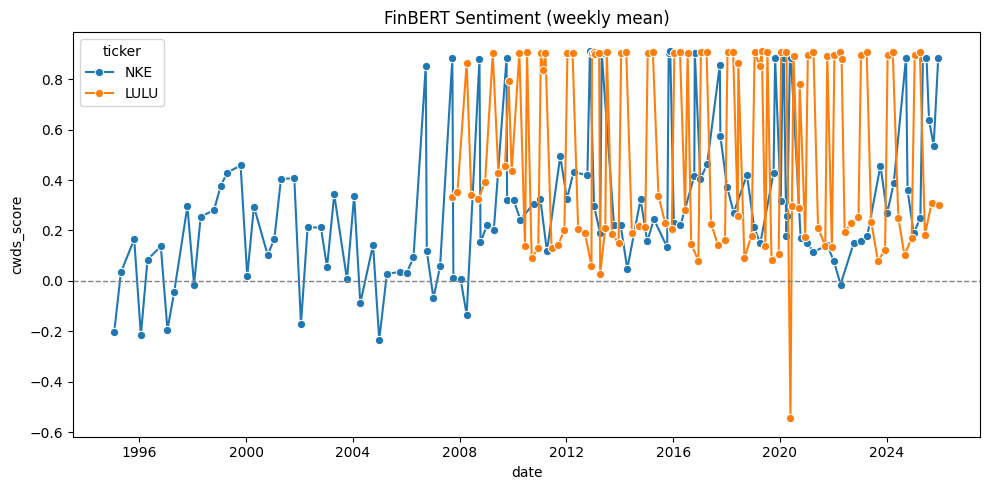

C:\Users\skurono\AppData\Local\Temp\ipykernel_16592\666790741.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=src.sort_values('cwds_score_mean'), x='cwds_score_mean', y='source', palette='coolwarm')


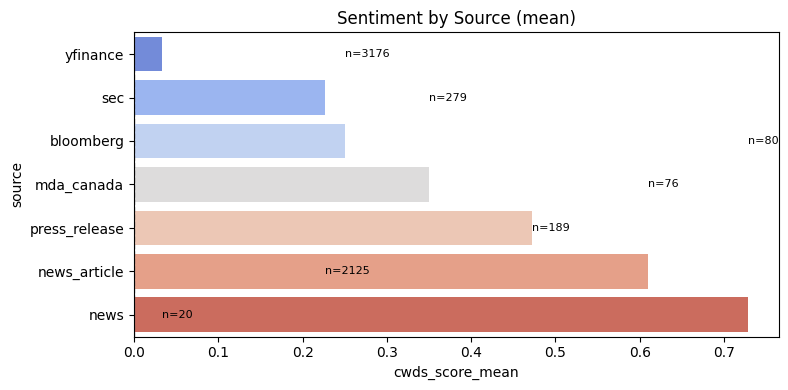

,ticker,mean,median,count
0,ATZ,0.076193,0.243805,1489
1,LULU,0.328350,0.469059,2132
2,NKE,0.300420,0.492635,2168
3,lulu,0.787585,0.867958,54
4,nike,0.606119,0.793007,26


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assumes score_df already exists; if not, uncomment to load
# score_df = pd.read_csv('nlp/processed_data/final/master_corpus_finbert.csv')

if 'date' in score_df.columns:
    score_df['date'] = pd.to_datetime(score_df['date'], errors='coerce', utc=True)

# 1) Sentiment over time by ticker (weekly mean)
if 'date' in score_df.columns:
    weekly = (score_df
              .dropna(subset=['date'])
              .groupby([pd.Grouper(key='date', freq='W'), 'ticker'])['cwds_score']
              .mean()
              .reset_index())
    plt.figure(figsize=(10,5))
    sns.lineplot(data=weekly, x='date', y='cwds_score', hue='ticker', marker='o')
    plt.title('FinBERT Sentiment (weekly mean)')
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

# 2) Sentiment by source/doc_type (bar with counts)
if {'source','cwds_score'} <= set(score_df.columns):
    src = score_df.groupby('source').agg(cwds_score_mean=('cwds_score','mean'), n=('id','count')).reset_index()
    plt.figure(figsize=(8,4))
    sns.barplot(data=src.sort_values('cwds_score_mean'), x='cwds_score_mean', y='source', palette='coolwarm')
    plt.title('Sentiment by Source (mean)')
    for i,row in src.iterrows():
        plt.text(row['cwds_score_mean'], i, f"n={row['n']}", va='center', ha='left', fontsize=8)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

# 3) Section-type sentiment per ticker (boxplot)
if {'section_type','cwds_score','ticker'} <= set(score_df.columns):
    plt.figure(figsize=(10,5))
    sns.boxplot(data=score_df, x='section_type', y='cwds_score', hue='ticker')
    plt.title('Sentiment by Section Type and Ticker')
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

summary = score_df.groupby('ticker')['cwds_score'].agg(['mean','median','count']).reset_index()
summary
